## Задача 1. Рекомендательные системы

Ваша задача — построить рекомендательную систему для социальной сети ОК. Для этого Вам необходимо обучить модель, которая для каждого пользователя (имя пользователя закодировано через customer_id) будет формировать список из рекомендуемых 7 групп (community_id), в которых он пока не состоит.

Примечание: Необходимо рекомендовать пользователю только те группы, в которые он еще не вступил, т.е. их нет в обучающей выборке.

Данные:
Для построения модели Вам будут доступны различные данные о пользователях и о том, в какие группы они вступили и когда, описания и данные групп, а также тестовый набор customer_id, для которых необходимо сделать прогноз. Ниже приведены описания всех полей в данных:

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from implicit.evaluation import mean_average_precision_at_k
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from lightfm.cross_validation import random_train_test_split

import warnings
warnings.filterwarnings('ignore')

### Загрузка и обработка данных

In [65]:
X = pd.read_csv('data.tsv.gz', sep = '\t', index_col=0).drop_duplicates()
X

/data/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,community_id,description,customers_count,messages_count,type,region_id,themeid,business_category,business_parent,customer_id,status,join_request_date
Unnamed: 0,,,,,,,,,,,,
0,00dbc35ec26c5b6452a3259194b2d2f74eae7141d2bc75...,"Ванга сказала: ""Выживет пчела - выживет челове...",2966,1,7,NaN,NaN,NaN,NaN,947224211267aefcc2e3e9c524fdf46ce329bc638e8bf1...,A,NaN
1,06107f1eae304c45d3e6324cc86f7d39662793a53b159b...,NaN,8982,2,7,1.042403e+10,246.0,NaN,NaN,b935c3390d82df612de19591d2dd16e1eff8e660746bb3...,A,NaN
2,06107f1eae304c45d3e6324cc86f7d39662793a53b159b...,NaN,8982,2,7,1.042403e+10,246.0,NaN,NaN,ff873dee9234ee290d92eb6c15d7179aabf0653dbed3b3...,A,NaN
3,06107f1eae304c45d3e6324cc86f7d39662793a53b159b...,NaN,8982,2,7,1.042403e+10,246.0,NaN,NaN,737ef0e849feda6cdfd350d19fcedaf17aebb757c0a1fc...,A,NaN
4,097e4dae68029ecc3c6183ed4386aff71dcac227cbaff7...,Читать внимательно!!! Причины попадания в чёрн...,1035,1,7,1.041779e+10,NaN,FAN_CLUB,BLOG,780fb8c178af972826ac0f84e42ac4c6c1dcdeeec0c4dd...,A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15592138,fd03f285e448b8bc593807c3b51efa53cd94b8d711401b...,NaN,490,1,7,3.791700e+04,NaN,HOUSE_OF_CULTURE,LEISURE_AND_ENTERTAINMENT,e992aa3179b691812203a827b2d229b3bcc41c31477ba7...,P,NaN
15592139,fd10d82ccd204ca4a86bad5b4923c41e0fa8b3c96dac59...,Любители футбола вам сюда,205,2,7,NaN,NaN,NaN,NaN,a8b43d4a5e9583edac068333ce010c559e03e6a33dbbfb...,P,NaN
15592144,fd93a38346c35aec0f6b89713206ef55e1bd67604942a5...,Чем интересна наша фамилия?\r\nЧем интересны м...,713,1,7,NaN,NaN,NaN,NaN,e70cced119a8f54a9f1bdcc4979735ebff7d817797c236...,P,NaN


#### Приведение к числовым индексам

In [29]:
communities = pd.DataFrame(X['community_id'].unique()).rename(columns = {0:'community_id'})
communities['community_id_new'] = communities.index
communities.to_csv('communities.tsv.gz', sep = '\t', compression = 'gzip', index = False)

communities.head(2)

,community_id,community_id_new
0,00dbc35ec26c5b6452a3259194b2d2f74eae7141d2bc75...,0
1,06107f1eae304c45d3e6324cc86f7d39662793a53b159b...,1


In [30]:
customers = pd.DataFrame(X['customer_id'].unique()).rename(columns = {0:'customer_id'})
customers['customer_id_new'] = customers.index
customers.to_csv('customers.tsv.gz', sep = '\t', compression = 'gzip', index = False)

customers.head(2)

,customer_id,customer_id_new
0,947224211267aefcc2e3e9c524fdf46ce329bc638e8bf1...,0
1,b935c3390d82df612de19591d2dd16e1eff8e660746bb3...,1


In [66]:
X = pd.merge(X, communities)
X = pd.merge(X, customers)

X = X.drop(columns=['community_id', 'customer_id'])
X.head(2)

,description,customers_count,messages_count,type,region_id,themeid,business_category,business_parent,status,join_request_date,community_id_new,customer_id_new
0,"Ванга сказала: ""Выживет пчела - выживет челове...",2966,1,7,NaN,NaN,NaN,NaN,A,NaN,0,0
1,Пчеловодство для начинающих и не только. Хотит...,3296,4,7,1.040023e+10,405.0,ANIMALS,PETS,A,NaN,1462,0


#### Обработка пропусков

In [67]:
X.isnull().sum()[X.isnull().sum()>0]

description           1548109
region_id             6991207
themeid               5366817
business_category     2631365
business_parent       2631365
join_request_date    11387551
dtype: int64

In [68]:
X['description'] = X['description'].fillna("")

X = X.fillna(-1)

In [40]:
X

,description,customers_count,messages_count,type,region_id,themeid,business_category,business_parent,status,join_request_date,community_id_new,customer_id_new
0,"Ванга сказала: ""Выживет пчела - выживет челове...",2966,1,7,-1.000000e+00,-1.0,-1,-1,A,-1.0,0,0
1,Пчеловодство для начинающих и не только. Хотит...,3296,4,7,1.040023e+10,405.0,ANIMALS,PETS,A,-1.0,1462,0
2,"Приветствуем всех,кто умеет,любит или просто х...",168216,3,7,1.040799e+10,209.0,CREATION,BLOG,A,-1.0,4120,0
3,Все только о розах........\nДелимся опытом выр...,41647,2,7,1.040799e+10,398.0,-1,-1,A,-1.0,6979,0
4,"Тра́ктор (новолат. tractor, «тягач») — безрель...",40994,38,7,1.040824e+10,56.0,-1,-1,A,-1.0,12089,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11530269,,187,2,7,-1.000000e+00,-1.0,CULTURAL_CENTER,LEISURE_AND_ENTERTAINMENT,I,-1.0,149086,1567772
11530270,,187,2,7,-1.000000e+00,-1.0,CULTURAL_CENTER,LEISURE_AND_ENTERTAINMENT,I,-1.0,149086,1567773
11530271,Певец и музыкант,84,1,7,1.040799e+10,249.0,MUSIC,BLOG,P,-1.0,149107,1568290
11530272,"Доброта - это то, что может услышать глухой и ...",317,4,7,1.521730e+05,-1.0,GOS_ORGANIZATION,GOS_ORGANIZATIONS,I,-1.0,149108,1568310


#### Приведение к числовому формату

In [69]:
X['region_id'] = X['region_id'].astype(int)
X['themeid'] = X['themeid'].astype(int)

X['join_request_date'] = X['join_request_date'].astype(int)

In [70]:
X['description'] = X['description'].apply(lambda x: 1 if len(x) > 0 else 0)

#### Кодирование категориальных признаков

In [44]:
X['business_parent'].nunique()

21

In [45]:
X['business_category'].nunique() - это тоже, через onehot

231

In [72]:
X = X.rename(columns = {'business_category':'bc', 'business_parent':'bp'})

label_enc_features = ['bc', 'bp']

one_hot = pd.get_dummies(X[label_enc_features])
X = X.drop(columns = label_enc_features)
X = X.join(one_hot)
   
X.head(5)  

,description,customers_count,messages_count,type,region_id,themeid,status,join_request_date,community_id_new,customer_id_new,...,bp_LEISURE_AND_ENTERTAINMENT,bp_MEDIA,bp_PERSON,bp_PETS,bp_POPULAR,bp_PROFESSIONAL_SERVICES,bp_SOCIAL_ORGANISATIONS,bp_SPORT,bp_TOURISM,bp_TRANSPORT
0,1,2966,1,7,-1,-1,A,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3296,4,7,10400232986,405,A,-1,1462,0,...,0,0,0,1,0,0,0,0,0,0
2,1,168216,3,7,10407994421,209,A,-1,4120,0,...,0,0,0,0,0,0,0,0,0,0
3,1,41647,2,7,10407994421,398,A,-1,6979,0,...,0,0,0,0,0,0,0,0,0,0
4,1,40994,38,7,10408237457,56,A,-1,12089,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
X['status'] = lab_enc.fit_transform(X['status'])

X['status'].unique()

array([0, 4, 3, 5, 1, 6, 2])

In [82]:
X['target'] = X['status'].apply(lambda x: 0 if x == 0 else 1)
X['target'].value_counts()

0    7276008
1    4254266
Name: target, dtype: int64

In [12]:
X = X.drop(columns = ['status'])

#### Масштабирование признаков

In [104]:
scaler = StandardScaler()
# MinMaxScaler
# Normalizer

X[X.columns] = scaler.fit_transform(X)

In [103]:
X.head(5)

,description,customers_count,messages_count,type,region_id,themeid,status,join_request_date,community_id_new,customer_id_new,...,bp_MEDIA,bp_PERSON,bp_PETS,bp_POPULAR,bp_PROFESSIONAL_SERVICES,bp_SOCIAL_ORGANISATIONS,bp_SPORT,bp_TOURISM,bp_TRANSPORT,target
0,0.393812,-0.464509,-0.237766,-0.059634,-0.039784,-0.299136,-0.751874,-0.111869,0,0,...,-0.152649,-0.256054,-0.190112,-0.064669,-0.097335,-0.201113,-0.064381,-0.154369,-0.023667,-0.764655
1,0.393812,-0.463189,-0.230026,-0.059634,0.002082,-0.299136,-0.751874,-0.111869,1462,0,...,-0.152649,-0.256054,5.260053,-0.064669,-0.097335,-0.201113,-0.064381,-0.154369,-0.023667,-0.764655
2,0.393812,0.196509,-0.232606,-0.059634,0.002113,-0.299136,-0.751874,-0.111869,4120,0,...,-0.152649,-0.256054,-0.190112,-0.064669,-0.097335,-0.201113,-0.064381,-0.154369,-0.023667,-0.764655
3,0.393812,-0.309781,-0.235186,-0.059634,0.002113,-0.299136,-0.751874,-0.111869,6979,0,...,-0.152649,-0.256054,-0.190112,-0.064669,-0.097335,-0.201113,-0.064381,-0.154369,-0.023667,-0.764655
4,0.393812,-0.312393,-0.142308,-0.059634,0.002114,-0.299136,-0.751874,-0.111869,12089,0,...,-0.152649,-0.256054,-0.190112,-0.064669,-0.097335,-0.201113,-0.064381,-0.154369,-0.023667,-0.764655


In [85]:
# X.to_csv('data_prepared.tsv.gz', sep = '\t', compression = 'gzip', index = False)

In [10]:
# X = pd.read_csv('data_prepared.tsv.gz', sep = '\t')

## Поиск рекомендаций

#### 1. Toп-20

In [107]:
top = X['community_id_new'].value_counts()[:20]

In [109]:
customer_id = 0
customer_groups = list(X[X['customer_id_new'] == customer_id]['community_id_new'])
customer_groups

[0, 1462, 4120, 6979, 12089]

In [116]:
# customer_recomms = 
[i for i in top.keys() if i not in customer_groups][:7]

[9510, 19909, 7781, 366, 2704, 394, 20440]

* Повторить для всех пользователей
* Не забыть вернуться к старым айдишникам

.

#### 2. Похожие группы

In [30]:
knn_train_df = X[:200].drop(columns = ['community_id_new', 'customer_id_new', 'target'])
nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(knn_train_df)
_, indices = nbrs.kneighbors(knn_train_df)

In [40]:
knn_df = pd.DataFrame(indices, columns = ['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7'])
knn_df['community_id'] = X[:200]['community_id_new']
knn_df = knn_df.drop_duplicates()
knn_df

,n1,n2,n3,n4,n5,n6,n7,community_id
0,0,83,5,94,64,54,60,0
1,1,37,48,52,61,121,14,1462
2,2,196,156,138,65,118,130,4120
3,3,21,197,4,32,12,34,6979
4,4,3,21,197,12,32,10,12089
...,...,...,...,...,...,...,...,...
195,195,190,112,191,108,186,119,7236
196,196,2,156,65,138,118,199,7463
197,197,12,32,34,77,10,14,7686
198,198,116,163,67,192,98,126,7720


In [49]:
list((knn_df[knn_df['community_id'] == 0].values[0][1:-1]))

array([83,  5, 94, 64, 54, 60])

In [50]:
customer_id = 0

customer_recomms_all = []

customer_groups = X[X['customer_id_new'] == customer_id]['community_id_new']
for group_id in customer_groups:
    customer_recomms_all += list((knn_df[knn_df['community_id'] == group_id].values[0][1:-1]))
    
top = pd.Series(customer_recomms_all).value_counts()
top

21     2
197    2
12     2
32     2
61     1
65     1
130    1
3      1
196    1
5      1
138    1
14     1
37     1
83     1
10     1
60     1
156    1
94     1
34     1
4      1
54     1
48     1
52     1
118    1
121    1
64     1
dtype: int64

In [51]:
[i for i in top.keys() if i not in customer_groups][:7]

[21, 197, 12, 32, 61, 65, 130]

### 3. Коллаборативная фильтрация

Пользователи со схожими вкусами выбирают одни и же группы.

**Матрица взаимодействия**

In [55]:
example = pd.DataFrame(np.array([['Группа1', 'Группа2', 'Группа3', 'Группа4', 'Группа5'], [0, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 1, 1, 0]]).T)
example.columns = ['', 'Пользователь1', 'Пользователь2', 'Пользователь3']
example

,,Пользователь1,Пользователь2,Пользователь3
0,Группа1,0,0,0
1,Группа2,1,0,1
2,Группа3,0,1,1
3,Группа4,1,0,1
4,Группа5,0,0,0


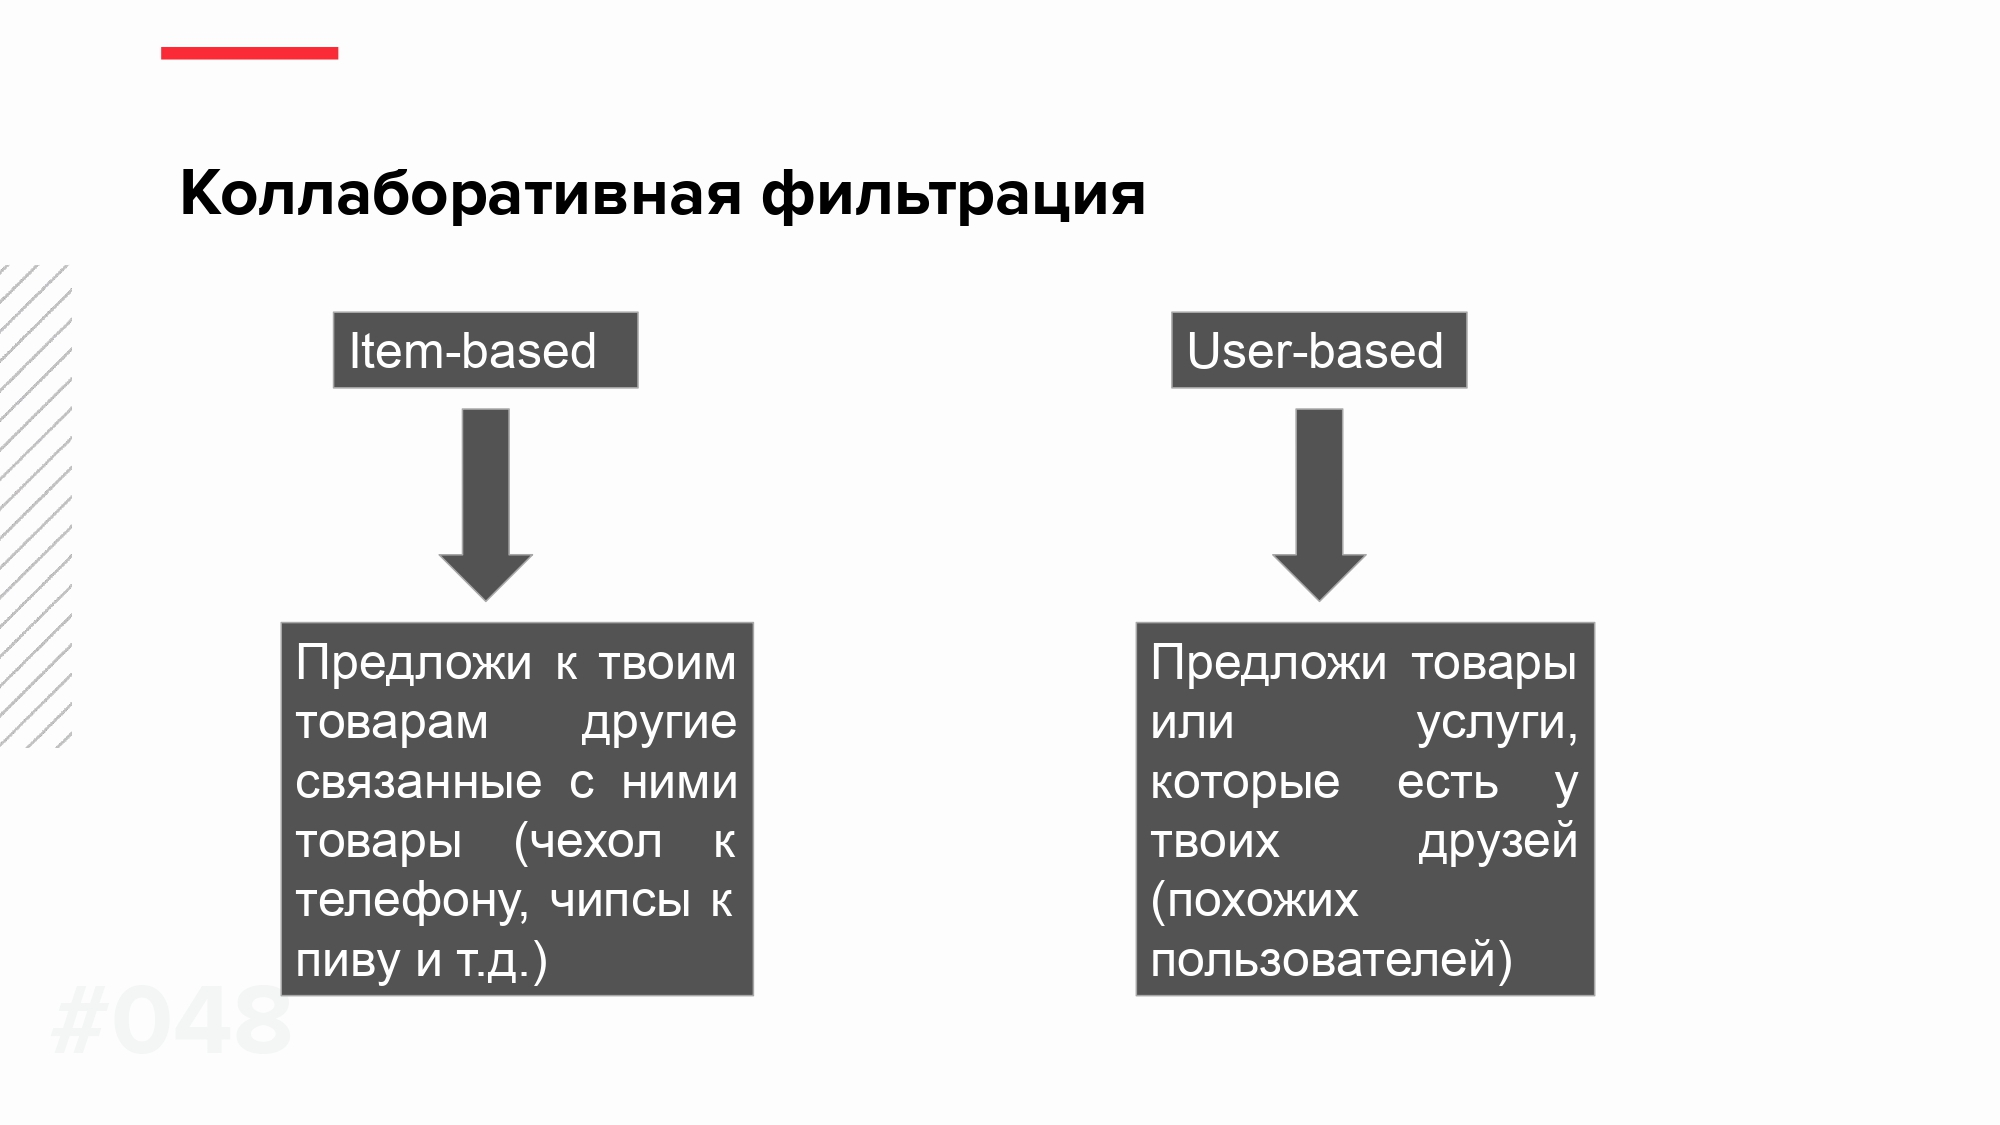

#### Пример user-based

In [61]:
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender

In [58]:
df_reduced = X[['community_id_new', 'customer_id_new']].drop_duplicates()

data_full = csr_matrix((np.ones((df_reduced.shape[0],)).astype(float), 
           (df_reduced['customer_id_new'].values, 
            df_reduced['community_id_new'].values)))

In [60]:
data_train, data_test = random_train_test_split(data_full)

In [64]:
cr = CosineRecommender()

cr.fit(data_train)

In [94]:
dftest_new = pd.DataFrame()
dftest_new['customer_id_new'] = customers['customer_id_new'][:200]

In [99]:
recs = cr.recommend(customer_id, data_full[dftest_new.values.squeeze()].astype(float))
customer_recomms = [i[0] for i in recs][:7]
customer_recomms

[220228, 1146217, 1146230, 356384, 1004445, 1052667, 1052754]

## Что еще можно было попробовать:

* Ещё один способ - Матричная факторизация (SVD)


* Другие метрики близости
  * Косинусное расстояние
  * Коэффициент корреляции Пирсона
  * Манхэттенское расстояние
  * Евклидово расстояние
  * Коэффициент Жаккара

  
* Совершенно точно - подбор гиперпараметров - того же k (любой):
  * GridSearchCV - подбор по сетке
  * Optuna - байесовский алгоритм быстрого подбора гиперпараметров
  

* Объединение нескольких решений:
  *	Взвешенная система, в которой результаты отдельных алгоритмов объединяются с помощью взвешенной суммы;
  *	Каскадная система, в которой алгоритмы обрабатывают данные по цепочке, уточняя результат;
